# 💻 Guia de Prática 6 💻

### 👉 Passos iniciais:

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Erick Nathan M. Alves & Victor Sidnei Cotta
@data: 16/11/2022
"""



#Importando as bibliotecas:
import numpy as np # importando biblioteca numpy
import matplotlib.pyplot as plt # importando biblioteca para plotar as figuras
import control as ct  #importando biblioteca python control systems

plt.close('all') #comando para fechar todas janelas de plot

#Exibição dos gráficos em janela externa:
#%matplotlib qt
#Exibição dos gráficos em no notebook:
%matplotlib inline



#Parâmetros do sistema:
La = .154
L1 = .155
Lt = .270
d = .02
mt = .005
rho = 1.23
c = 2.05
mi = 5
g = 9.81

#Constantes do modelo:
K1 = ((d*rho*c*La*L1)/(2*mt*(((Lt**2)/12)+(d**2))))
K2 = ((g*d)/(((Lt**2)/12)+(d**2)))
K3 = ((mi*d**2)/(mt*(((Lt**2)/12)+(d**2))))

#Dinâmica do sistema:
X0 = [0, 0] #condições iniciais

#Caracterizando o modelo, em espaço de estados:
def model_update(t, x, u, params):
    
    x1 = x[0] # posicao
    x2 = x[1] # velocidade
    M = u[1] # massa variável
    u = u[0] # sinal de controle

    #Constantes do modelo:
    C1 = ((d*rho*c*La*L1)/(2*M*(((Lt**2)/12)+(d**2))))
    C2 = ((g*d)/(((Lt**2)/12)+(d**2)))
    C3 = ((mi*d**2)/(M*(((Lt**2)/12)+(d**2))))

    #Retorna as derivadas:
    return [x2, ((C1*(np.cos(x1)**2)*u) - ((C2*np.sin(x1)) + (C3*x2)))]

#Função que retorna o estado:
def model_output(t, x, u, params):
    return x

#Instanciando o sistema:
fanplate = ct.NonlinearIOSystem(model_update, model_output, states=2, name='fanplate', inputs=('u', 'u_m'), outputs=('x1','x2'))

### 👉 Item 2:

* Levando o sistema ao ponto de operação (27°):

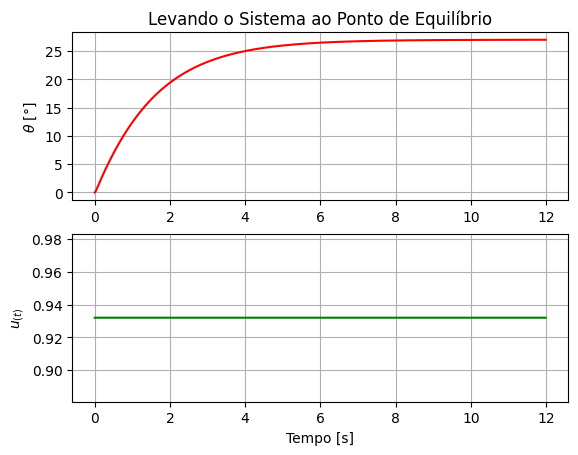

In [3]:
#Parâmetros de simulação:
t = np.arange(0, 12, .01) #criando array de tempo
pop = 27 #Ponto de operação
u_eq = (((K2/K1)*np.sin(np.radians(pop)))/(np.cos(np.radians(pop))**2)) #sinal que leva ao ponto desejado
u = u_eq*np.ones(t.shape) #criando array com para o sinal

#Massa constante:
mc = mt*np.ones(t.shape)

#Solucionando o sistema em si:
t, x = ct.input_output_response(fanplate, t, [u, mc], X0=X0)
y = x[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(1)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(t, np.degrees(y),'red', label='$\\theta_{(t)}$')
plt.ylabel('$\\theta$ [°]')
plt.title('Levando o Sistema ao Ponto de Equilíbrio')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, u, 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Aplicação de um degrau de +5° em torno do equilíbrio:

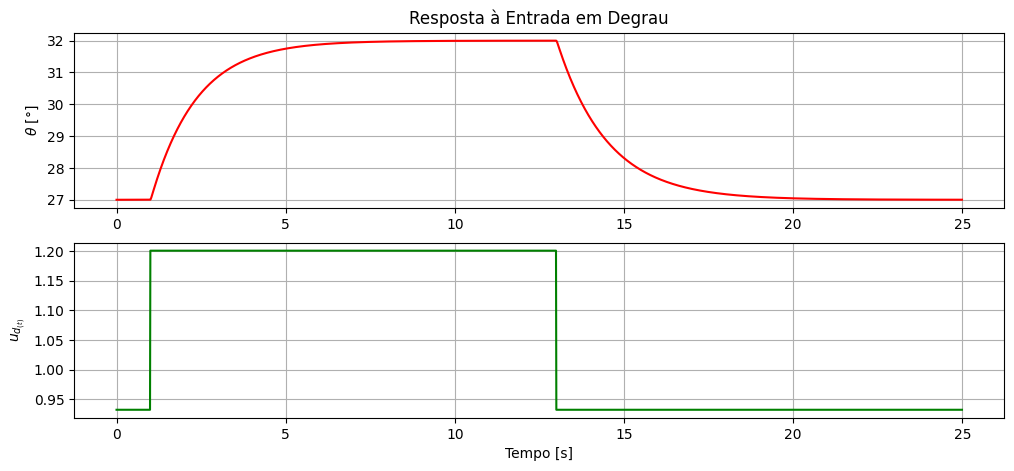

In [4]:
#Parâmetros de simulação:
X0 = [np.radians(27), 0]
Ad = 5 #Amplitude do degrau
ud = (((K2/K1)*np.sin(np.radians(pop+Ad)))/(np.cos(np.radians(pop+Ad))**2)) #sinal que aplica o degrau
td = np.arange(0, 25, .01) #criando array de tempo
#Criação do degrau:
u = np.hstack(((u_eq*np.ones(100)), (ud*np.ones(1200)), (u_eq*np.ones(1200))))

#Massa constante:
mc = mt*np.ones(td.shape)

#Solucionando o sistema em si:
td, xd = ct.input_output_response(fanplate, td, [u, mc], X0=X0)
yd = xd[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(2)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(td, np.degrees(yd),'red', label='$\\theta_{(t)}$')
plt.ylabel('$\\theta$ [°]')
plt.title('Resposta à Entrada em Degrau')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(td, u, 'green', label='$u_{d_{(t)}}$')
plt.ylabel('$u_{d_{(t)}}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Obtenção dos parâmetros para modelo de Ziegler-Nichols, por resposta ao degrau positivo (borda de subida):


 Resposta ao degrau (+5°): 	A = 1	 B = 1.9606	 C = 2.5212


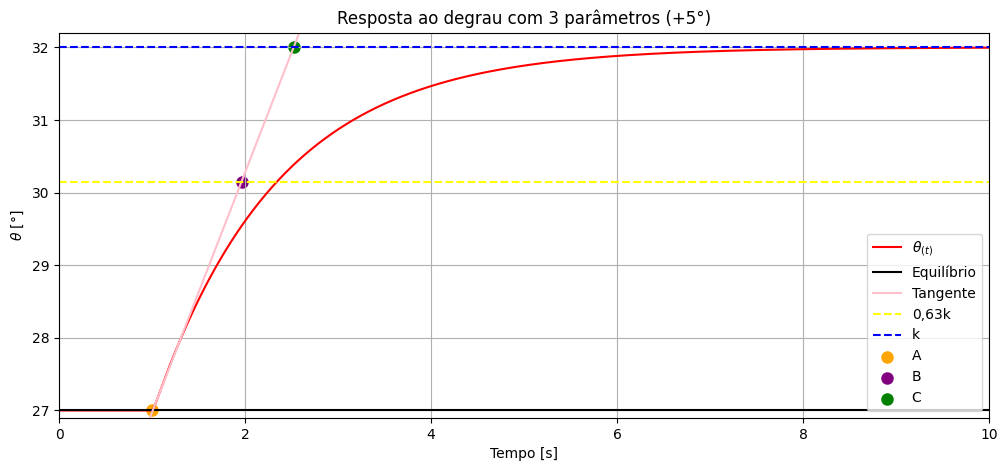

In [5]:
#Equilíbrio:
y0 = (pop*np.ones(td.shape))

#Reta tangente:
coef_ang = 3.3
coef_lin = 23.68
y1 = (coef_ang*td + coef_lin) #ajustada graficamente

#Atraso / tempo morto / fase:
A = 1 #obtido graficamente (há uma antecipação que não existe, o atraso é zero aqui, portanto o tempo morto também é zero)!!!!!!!!!!!!!!!

#Reta 0,63K:
y2 = ((pop+(0.63*Ad))*np.ones(td.shape))
B = (((pop+(0.63*Ad))-coef_lin)/coef_ang)

#Reta K:
y3 = ((pop+Ad)*np.ones(td.shape))
C = (((pop+Ad)-coef_lin)/coef_ang)

print("\n Resposta ao degrau (+5°): \tA = " + str(round(A, 4)) + "\t B = " + str(round(B, 4)) + "\t C = " + str(round(C, 4)))

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(3)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(td, np.degrees(yd),'red',label='$\\theta_{(t)}$')
plt.plot(td, y0,'black',label='Equilíbrio')
plt.plot(td, y1,'pink',label='Tangente')
plt.plot(td, y2,'yellow',ls='--',label='0,63k')
plt.plot(td, y3,'blue',ls='--',label='k')
plt.scatter(A, pop, c='orange', linewidths=3, label='A')
plt.scatter(B, (pop+(0.63*Ad)), c='purple', linewidths=3, label='B')
plt.scatter(C, (pop+Ad), c='green', linewidths=3, label='C')
plt.ylabel('$\\theta$ [°]')
plt.xlabel('Tempo [s]')
plt.xlim(0, 10)
plt.legend(loc='lower right')
plt.ylim(26.9, 32.2)
plt.title('Resposta ao degrau com 3 parâmetros (+5°)')
plt.grid()
plt.show()

* Validação do modelo:


 tau: 	 1.5212

G: 
  0.3245
-----------
1.521 s + 1



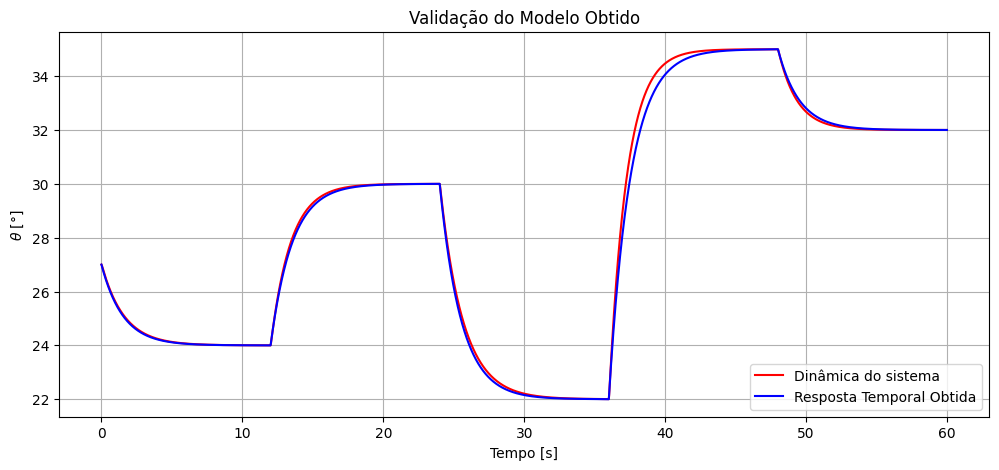

In [6]:
#Resposta ao degrau:
tau = (C-A)
print(f'\n tau: \t {round(tau, 4)}')
theta = 0
def sd(t, k, tau, theta):
    return (k*(1-np.exp((theta-t)/tau)))

#Criação de degraus:
udeg = []
kdeg = [-3, 3, -5, 8, 5]
for i in range(len(kdeg)):
    udeg.append((((K2/K1)*np.sin(np.radians(pop+kdeg[i])))/(np.cos(np.radians(pop+kdeg[i]))**2))*np.ones(1200))
uv = np.hstack(udeg)

tv = np.arange(0, 60, .01)

ysv = np.hstack(((pop+sd(tv[:1200], -3, tau, theta)), ((pop+kdeg[0])+sd(tv[:1200], 6, tau, theta)), ((pop+kdeg[1])+sd(tv[:1200], -8, tau, theta)), ((pop+kdeg[2])+sd(tv[:1200], 13, tau, theta)), ((pop+kdeg[3])+sd(tv[:1200], -3, tau, theta))))

#Parâmetros de simulação:
X0 = [np.radians(pop), 0]

#Massa constante:
mc = mt*np.ones(tv.shape)

#Solucionando o sistema em si:
tv, xv = ct.input_output_response(fanplate, tv, [uv, mc], X0=X0)
yv = np.degrees(xv[0])

#Função de transferência para um sistema de primeira ordem superamortecido:
s = ct.tf('s')
K = (np.radians(Ad)/(ud-u_eq)) #ganho estático do sistema
G = (K/((tau*s)+1))
print('\nG: ' + str(G))

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(4)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(tv, yv, 'red', label='Dinâmica do sistema')
plt.plot(tv, ysv,'blue',label='Resposta Temporal Obtida')
plt.ylabel('$\\theta$ [°]')
plt.xlabel('Tempo [s]')
plt.legend(loc='lower right')
plt.title('Validação do Modelo Obtido')
plt.grid()
plt.show()

### 👉 Item 3:

* Inclusão do atraso ao modelo obtido:

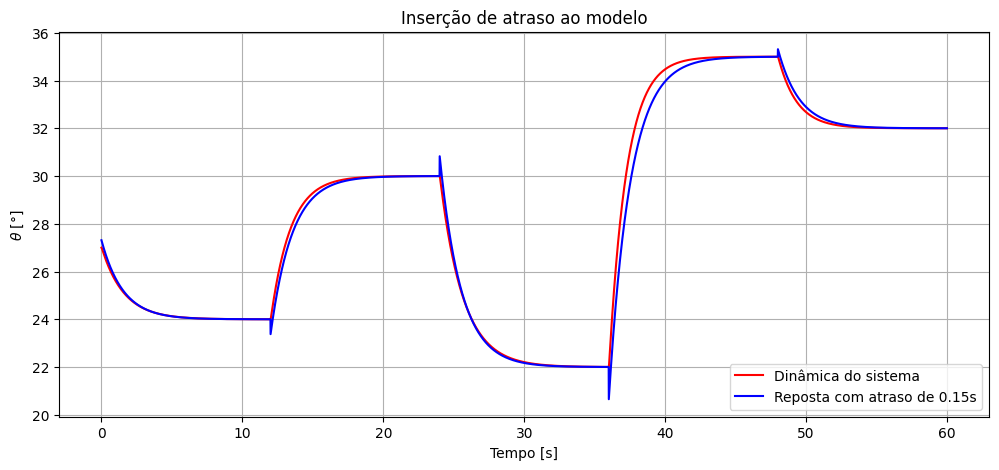

In [7]:
theta = 0.15

td1 = np.arange(0, 60, .01)

yd1 = np.hstack(((pop+sd(tv[:1200], -3, tau, theta)), ((pop+kdeg[0])+sd(tv[:1200], 6, tau, theta)), ((pop+kdeg[1])+sd(tv[:1200], -8, tau, theta)), ((pop+kdeg[2])+sd(tv[:1200], 13, tau, theta)), ((pop+kdeg[3])+sd(tv[:1200], -3, tau, theta))))

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(5)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(tv, yv, 'red', label='Dinâmica do sistema')
plt.plot(tv, yd1,'blue',label='Reposta com atraso de 0.15s')
plt.ylabel('$\\theta$ [°]')
plt.xlabel('Tempo [s]')
plt.legend(loc='lower right')
plt.title('Inserção de atraso ao modelo')
plt.grid()
plt.show()

### 👉 Itens 4 e 5:

* Incluindo atraso por aproximação de Padé (ordens: 1, 3, 5 e 9):

In [8]:
#Funções de transferência das ordens especificadas:
Gd = []
o_p = [1, 3, 5, 9]
for i in range(len(o_p)):
    #Aproximação de padé:
    N = ct.pade(0.15, o_p[i])
    #Função de transferência do atraso:
    Gd.append(ct.TransferFunction(np.array(N[0]), np.array(N[1])))
    print(f'\n Gd{o_p[i]}: \t {Gd[i]}')


 Gd1: 	 
-s + 13.33
----------
s + 13.33


 Gd3: 	 
-s^3 + 80 s^2 - 2667 s + 3.556e+04
----------------------------------
s^3 + 80 s^2 + 2667 s + 3.556e+04


 Gd5: 	 
-s^5 + 200 s^4 - 1.867e+04 s^3 + 9.956e+05 s^2 - 2.987e+07 s + 3.982e+08
------------------------------------------------------------------------
s^5 + 200 s^4 + 1.867e+04 s^3 + 9.956e+05 s^2 + 2.987e+07 s + 3.982e+08


 Gd9: 	 
-s^9 + 600 s^8 - 1.76e+05 s^7 + 3.285e+07 s^6 - 4.271e+09 s^5 + 3.986e+11 s^4 - 2.657e+13 s^3 + 1.215e+15 s^2 - 3.442e+16 s + 4.589e+17
---------------------------------------------------------------------------------------------------------------------------------------
s^9 + 600 s^8 + 1.76e+05 s^7 + 3.285e+07 s^6 + 4.271e+09 s^5 + 3.986e+11 s^4 + 2.657e+13 s^3 + 1.215e+15 s^2 + 3.442e+16 s + 4.589e+17



### 👉 Item 6:

* Simulação do sistema com atraso:

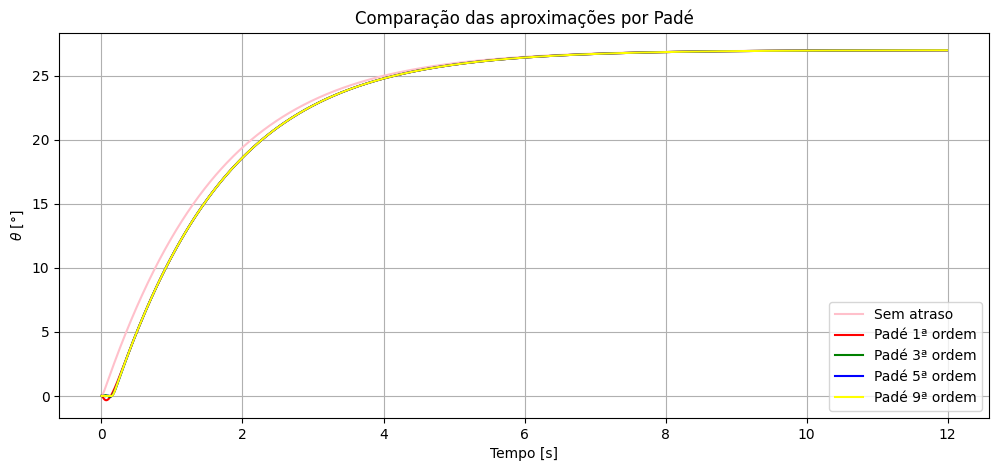

In [9]:
#Massa constante:
mc = mt*np.ones(t.shape)

y_malha = []
u = u_eq*np.ones(t.shape) #criando array com para o sinal
for i in range(len(Gd)):
    atraso = ct.tf2io(Gd[i], name='atraso', inputs='u', outputs='y')
    malha = ct.InterconnectedSystem(
        (atraso, fanplate), name='malha', 
        connections=(('atraso.u',), ('fanplate.u', 'atraso.y')), 
        inplist=('atraso.u', 'fanplate.u_m'),
        outlist=('fanplate.x1', 'fanplate.x2')
    )
    X0 = np.zeros(o_p[i]+2)

    t, ym = ct.input_output_response(malha, t, [u, mc], X0)
    y_malha.append(ym[0])

#Parâmetros de simulação:
X0 = [0, 0]
tn = np.arange(0, 12, .01) #criando array de tempo
u = u_eq*np.ones(tn.shape) #criando array com para o sinal

#Massa constante:
mc = mt*np.ones(tn.shape)

#Solucionando o sistema em si:
tn, x = ct.input_output_response(fanplate, tn, [u, mc], X0=X0)
y = x[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(6)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(tn, np.degrees(y), 'pink', label='Sem atraso')
plt.plot(t, np.degrees(y_malha[0]), 'red', label='Padé 1ª ordem')
plt.plot(t, np.degrees(y_malha[1]),'green',label='Padé 3ª ordem')
plt.plot(t, np.degrees(y_malha[2]),'blue',label='Padé 5ª ordem')
plt.plot(t, np.degrees(y_malha[3]),'yellow',label='Padé 9ª ordem')
plt.ylabel('$\\theta$ [°]')
plt.xlabel('Tempo [s]')
plt.legend(loc='lower right')
plt.title('Comparação das aproximações por Padé')
plt.grid()
plt.show()


### 👉 Item 7:

* Comparação resposta ao degrau com atraso, por aproximação de Padé de 5ª ordem:

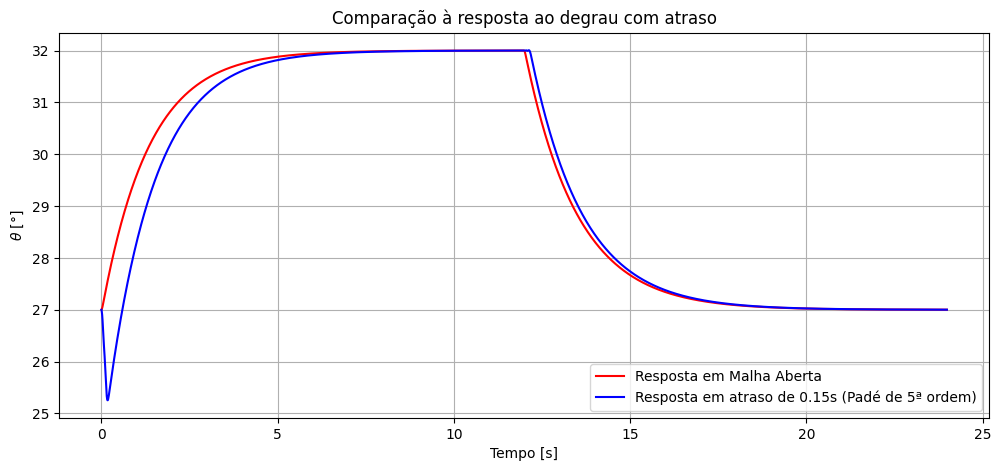

In [10]:
#Parâmetros de simulação:
X0 = [np.radians(pop), 0]

#Criação do degrau:
u = np.hstack(((ud*np.ones(1200)), (u_eq*np.ones(1200)))) 
t = np.arange(0, 24, .01) #criando array de tempo

#Massa constante:
mc = mt*np.ones(t.shape)

#Solucionando o sistema em si:
t, xdeg = ct.input_output_response(fanplate, t, [u, mc], X0=X0)
ydeg = xdeg[0]

atraso = ct.tf2io(Gd[2], name='atraso', inputs='u', outputs='y')
malha = ct.InterconnectedSystem(
    (atraso, fanplate), name='malha', 
    connections=(('atraso.u',), ('fanplate.u', 'atraso.y')), 
    inplist=('atraso.u', 'fanplate.u_m'),
    outlist=('fanplate.x1', 'fanplate.x2')
)
X0 = np.array([0, 0, 0, 0, 0, np.radians(pop), 0])

#Massa constante:
mc = mt*np.ones(t.shape)

t, xm = ct.input_output_response(malha, t, [u, mc], X0)
y_md = xm[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(7)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(t, np.degrees(ydeg), 'red', label='Resposta em Malha Aberta')
plt.plot(t, np.degrees(y_md),'blue',label='Resposta em atraso de 0.15s (Padé de 5ª ordem)')
plt.ylabel('$\\theta$ [°]')
plt.xlabel('Tempo [s]')
plt.legend(loc='lower right')
plt.title('Comparação à resposta ao degrau com atraso')
plt.grid()
plt.show()

### 👉 Item 8:

* Controlador Proporcional - Ziegler Nichols:

In [11]:
# Constantes via parâmetros de Ziegler Nichols - Tabelas 8.6 e 8.7 (Garcia, 2017):
kd = (np.radians(Ad)/(ud-u_eq))
Kc_pzn = (tau/(kd*theta))
print(f'\nKc: \t {round(Kc_pzn, 4)}')



Kc: 	 31.249


* Controlador Proporcional - CHR:

In [12]:
# Constantes via parâmetros de CHR - Tabela 8.9 (Garcia, 2017):
Kc_pchr = ((0.3*tau)/(kd*theta))
print(f'\nKc: \t {round(Kc_pchr, 4)}')


Kc: 	 9.3747


* Controlador Proporcional Integral - Ziegler Nichols:

In [13]:
# Constantes via parâmetros de Ziegler Nichols - Tabelas 8.6 e 8.7 (Garcia, 2017):
Kc_pizn = ((0.9*tau)/(kd*theta))
Ti_pizn = ((10*theta)/3)
print(f'\nKc: \t {round(Kc_pizn, 4)}')
print(f'\nTi: \t {round(Ti_pizn, 4)}')


Kc: 	 28.1241

Ti: 	 0.5


* Controlador Proporcional Integral - CHR:

In [14]:
# Constantes via parâmetros de CHR - Tabela 8.9 (Garcia, 2017):
Kc_pichr = ((0.6*tau)/(kd*theta))
Ti_pichr = (4*theta)
print(f'\nKc: \t {round(Kc_pichr, 4)}')
print(f'\nTi: \t {round(Ti_pichr, 4)}')


Kc: 	 18.7494

Ti: 	 0.6


### 👉 Item 10:

* Preparando respostas das malhas para r = [0 1 0 −1 0.5 1 −0.5 0]:

In [15]:
#Array de tempo:
t = np.arange(0, 64, .01)

#Preparando o sinal de referência:
r0 = [0, 1, 0, -1, 0.5, 1, -0.5, 0]
rs = []
us = []
for i in range(len(r0)):
    ri = np.radians(pop+(Ad*r0[i]))
    rs.append(ri*np.ones(800))
    us.append((((K2/K1)*np.sin(ri))/(np.cos(ri)**2))*np.ones(800))
r = np.hstack(rs)
u = np.hstack(us)

#Preparando o sinal de controle de operação:
u0 = u_eq*np.ones(t.shape)

#Preparando os controladores:

#Definição das funções de transferência:
ft_pzn = ct.tf(Kc_pzn, 1) # P - Ziegler Nichols
ft_pchr = ct.tf(Kc_pchr, 1) # P - CHR
ft_pizn1 = ct.tf(Kc_pizn, 1) # PI - Ziegler Nichols (Parte Proporcional)
ft_pizn2 = (Kc_pizn/(Ti_pizn*s)) # PI - Ziegler Nichols (Parte Integral)
ft_pichr1 = ct.tf(Kc_pichr, 1) # PI - CHR (Parte Proporcional)
ft_pichr2 = (Kc_pichr/(Ti_pichr*s)) # PI - CHR (Parte Integral)

#Definindo os subsistemas em formato de entradas e saídas:
sys_pzn = ct.tf2io(ft_pzn, name='pzn', inputs='u', outputs='y')
sys_pchr = ct.tf2io(ft_pchr, name='pchr', inputs='u', outputs='y')
sys_pizn1 = ct.tf2io(ft_pizn1, name='pizn1', inputs='u', outputs='y')
sys_pizn2 = ct.tf2io(ft_pizn2, name='pizn2', inputs='u', outputs='y')
sys_pichr1 = ct.tf2io(ft_pichr1, name='pichr1', inputs='u', outputs='y')
sys_pichr2 = ct.tf2io(ft_pichr2, name='pichr2', inputs='u', outputs='y')

# Atraso:
atraso = ct.tf2io(Gd[-2], name='atraso', inputs='u', outputs='y')

#Massa constante:
mc = mt*np.ones(t.shape)

# Malha aberta:
X0 = [0, 0]
t, xout = ct.input_output_response(fanplate, t, [u, mc], X0)
ma = xout[0]

* Controlador Proporcional - Ziegler Nichols:

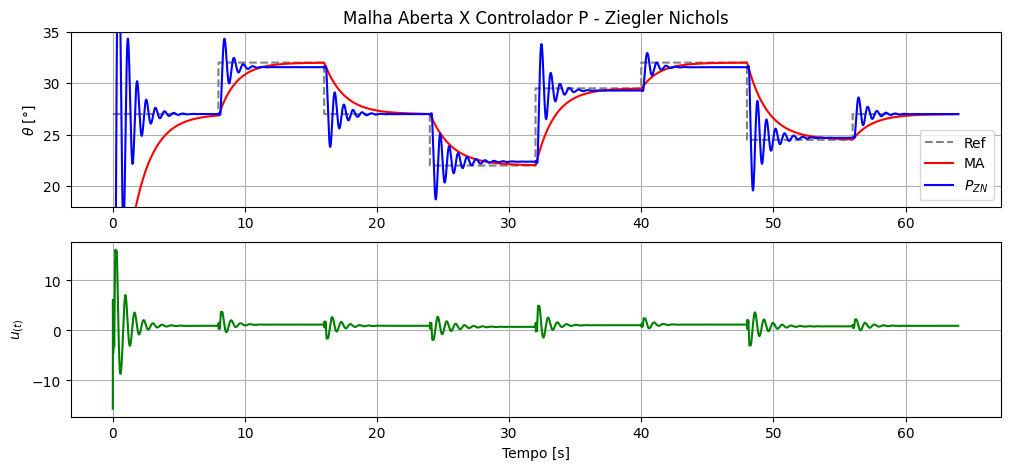

In [16]:
#Conexão da malha fechada:
closed_loop1 = ct.InterconnectedSystem(
    (fanplate, atraso, sys_pzn), name='closed_loop1', 
    connections=(('pzn.u', '-fanplate.x1'), ('atraso.u', 'pzn.y'), ('fanplate.u', 'atraso.y')), 
    inplist=('pzn.u', 'atraso.u', 'fanplate.u_m'),
    inputs=('xref', 'u0', 'u_m'),
    outlist=('fanplate.x1', 'fanplate.x2', 'fanplate.u'),
    outputs=('x1', 'x2', 'u')
)

#Massa constante:
mc = mt*np.ones(t.shape)

# Simulando Malha Fechada:
X0 = np.zeros(7)
t, xout = ct.input_output_response(closed_loop1, t, [r, u0, mc], X0)
cpzn = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(8)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(t, np.degrees(r), 'gray', linestyle='dashed', label='Ref')
plt.plot(t, np.degrees(ma), 'red', label='MA')
plt.plot(t, np.degrees(cpzn),'blue',label='$P_{ZN}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('Malha Aberta X Controlador P - Ziegler Nichols')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Controlador Proporcional - CHR:

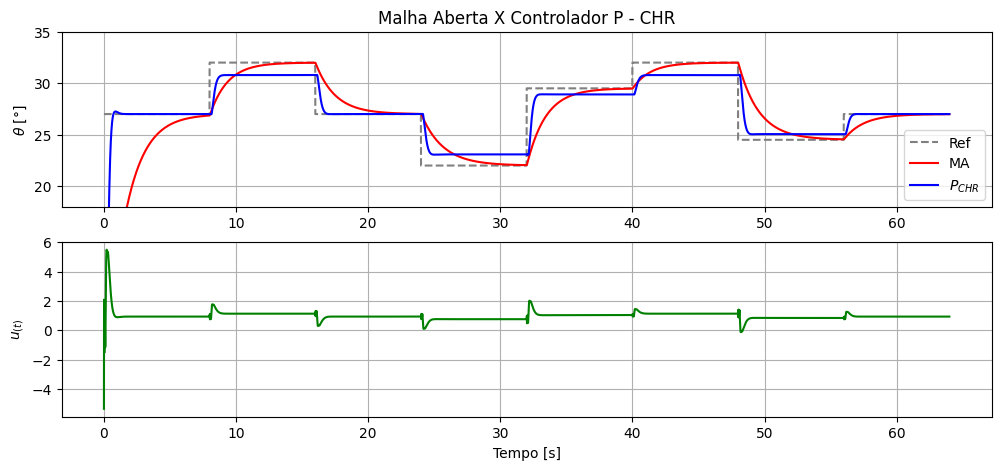

In [17]:
#Conexão da malha fechada:
closed_loop2 = ct.InterconnectedSystem(
    (fanplate, atraso, sys_pchr), name='closed_loop2', 
    connections=(('pchr.u', '-fanplate.x1'), ('atraso.u', 'pchr.y'), ('fanplate.u', 'atraso.y')), 
    inplist=('pchr.u', 'atraso.u', 'fanplate.u_m'),
    inputs=('xref', 'u0', 'u_m'),
    outlist=('fanplate.x1', 'fanplate.x2', 'fanplate.u'),
    outputs=('x1', 'x2', 'u')
)

#Massa constante:
mc = mt*np.ones(t.shape)

# Simulando Malha Fechada:
X0 = np.zeros(7)
t, xout = ct.input_output_response(closed_loop2, t, [r, u0, mc], X0)
cpchr = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(9)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(t, np.degrees(r), 'gray', linestyle='dashed', label='Ref')
plt.plot(t, np.degrees(ma), 'red', label='MA')
plt.plot(t, np.degrees(cpchr),'blue',label='$P_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('Malha Aberta X Controlador P - CHR')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Controlador Proporcional Integral - Ziegler Nichols:

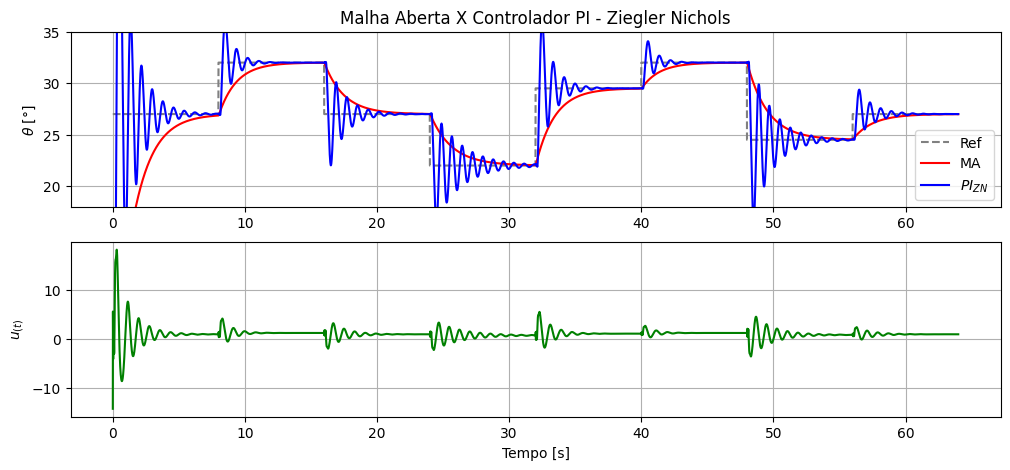

In [18]:
#Conexão da malha fechada:
closed_loop3 = ct.InterconnectedSystem(
    (fanplate, atraso, sys_pizn1, sys_pizn2), name='closed_loop3', 
    connections=(('pizn1.u', '-fanplate.x1'), ('atraso.u', 'pizn1.y'), ('pizn2.u', '-fanplate.x1'), ('atraso.u', 'pizn2.y'), ('fanplate.u', 'atraso.y')), 
    inplist=('pizn1.u', 'pizn2.u', 'atraso.u', 'fanplate.u_m'),
    inputs=('xref1', 'xref2', 'u0', 'u_m'),
    outlist=('fanplate.x1', 'fanplate.x2', 'fanplate.u'),
    outputs=('x1', 'x2', 'u')
)

#Massa constante:
mc = mt*np.ones(t.shape)

# Simulando Malha Fechada:
X0 = np.zeros(7)
t, xout = ct.input_output_response(closed_loop3, t, [r, r, u0, mc], X0)
cpizn = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(10)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(t, np.degrees(r), 'gray', linestyle='dashed', label='Ref')
plt.plot(t, np.degrees(ma), 'red', label='MA')
plt.plot(t, np.degrees(cpizn),'blue',label='$PI_{ZN}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('Malha Aberta X Controlador PI - Ziegler Nichols')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Controlador Proporcional Integral - CHR:

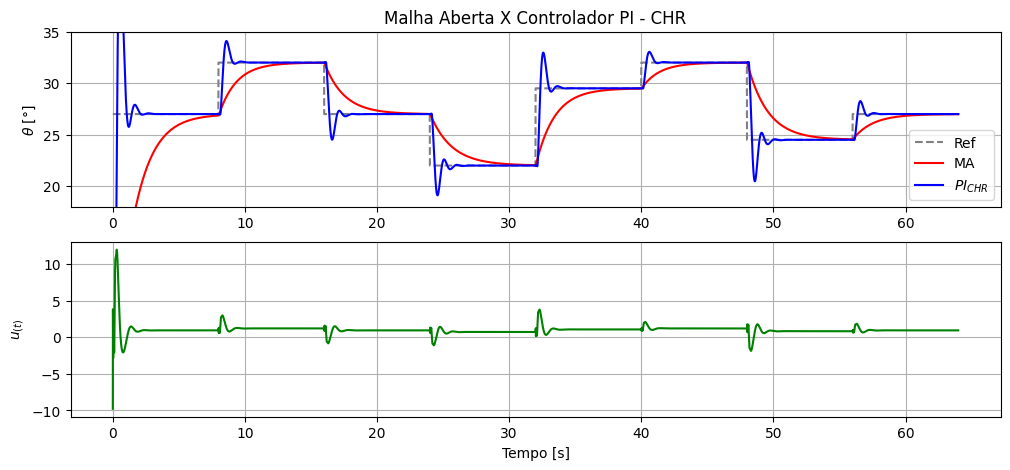

In [19]:
#Conexão da malha fechada:
closed_loop4 = ct.InterconnectedSystem(
    (fanplate, atraso, sys_pichr1, sys_pichr2), name='closed_loop4', 
    connections=(('pichr1.u', '-fanplate.x1'), ('atraso.u', 'pichr1.y'), ('pichr2.u', '-fanplate.x1'), ('atraso.u', 'pichr2.y'), ('fanplate.u', 'atraso.y')), 
    inplist=('pichr1.u', 'pichr2.u', 'atraso.u', 'fanplate.u_m'),
    inputs=('xref1', 'xref2', 'u0', 'u_m'),
    outlist=('fanplate.x1', 'fanplate.x2', 'fanplate.u'),
    outputs=('x1', 'x2', 'u')
)

#Massa constante:
mc = mt*np.ones(t.shape)

# Simulando Malha Fechada:
X0 = np.zeros(7)
t, xout = ct.input_output_response(closed_loop4, t, [r, r, u0, mc], X0)
cpichr = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(11)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(t, np.degrees(r), 'gray', linestyle='dashed', label='Ref')
plt.plot(t, np.degrees(ma), 'red', label='MA')
plt.plot(t, np.degrees(cpichr),'blue',label='$PI_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('Malha Aberta X Controlador PI - CHR')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Comparação entre os controladores:

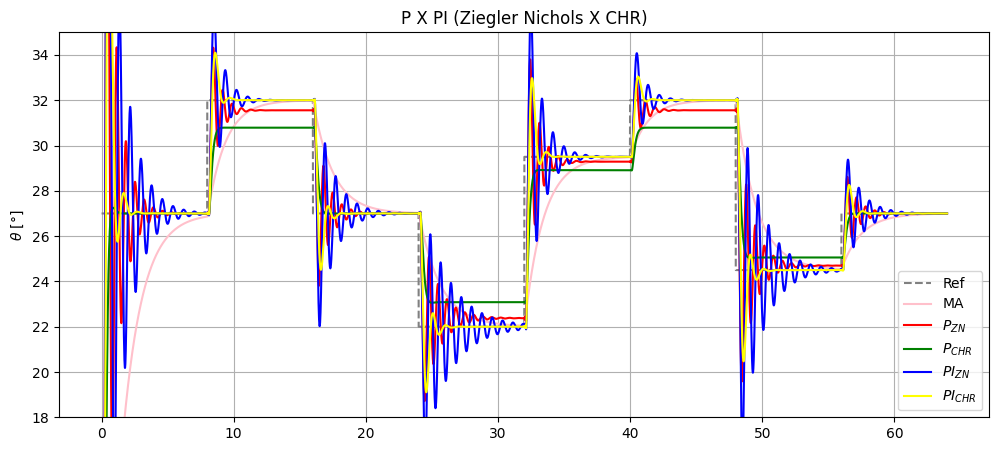

In [20]:
#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(12)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(t, np.degrees(r), 'gray', linestyle='dashed', label='Ref')
plt.plot(t, np.degrees(ma), 'pink', label='MA')
plt.plot(t, np.degrees(cpzn),'red',label='$P_{ZN}$')
plt.plot(t, np.degrees(cpchr),'green',label='$P_{CHR}$')
plt.plot(t, np.degrees(cpizn),'blue',label='$PI_{ZN}$')
plt.plot(t, np.degrees(cpichr),'yellow',label='$PI_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('P X PI (Ziegler Nichols X CHR)')
plt.grid()
plt.show()

* Rejeição a perturbação:

In [21]:
#Array de tempo:
tm = np.arange(0, 15, .01)

#Massa variável:
mv = []
for i in range(len(tm)):
    if(tm[i] <= 2):
        mv.append(mt)
    elif(tm[i] <= 12):
        mv.append(1.2*mt)
    else:
        mv.append(mt)

#Sinais de controle:
rm = np.radians(pop)*np.ones(tm.shape)
u0 = u_eq*np.ones(tm.shape)
u = u_eq*np.ones(tm.shape)

# Malha aberta:
X0 = [0, 0]
tm, xout = ct.input_output_response(fanplate, tm, [u, mv], X0)
ma = xout[0]

* Controlador Proporcional - Ziegler Nichols:

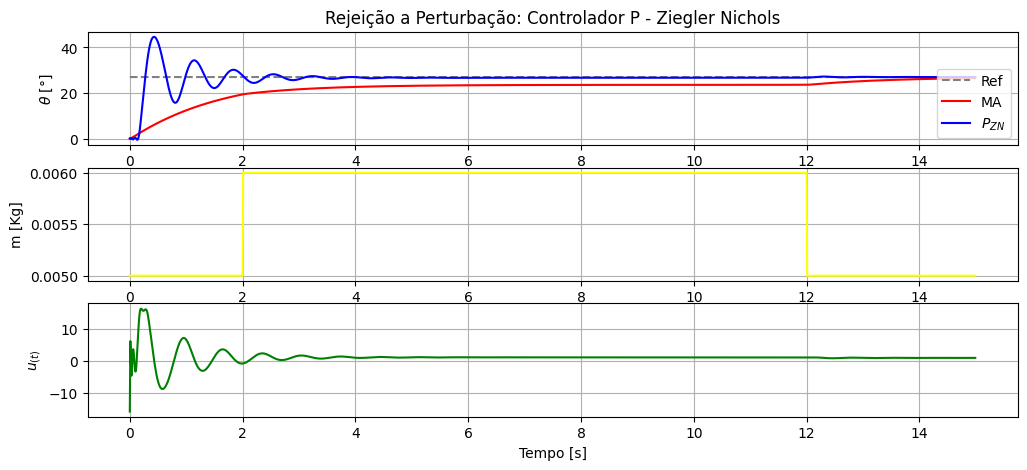

In [22]:
# Simulando a Malha Fechada:
X0 = np.zeros(7)
tm, xout = ct.input_output_response(closed_loop1, tm, [rm, u0, mv], X0)
mcpzn = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(13)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(3, 1, 1)
plt.plot(tm, np.degrees(rm), 'gray', linestyle='dashed', label='Ref')
plt.plot(tm, np.degrees(ma), 'red', label='MA')
plt.plot(tm, np.degrees(mcpzn),'blue',label='$P_{ZN}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.title('Rejeição a Perturbação: Controlador P - Ziegler Nichols')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(tm, mv, 'yellow', label='$m_{(t)}$')
plt.ylabel('m [Kg]')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(tm, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()

plt.show()

* Controlador Proporcional - CHR:

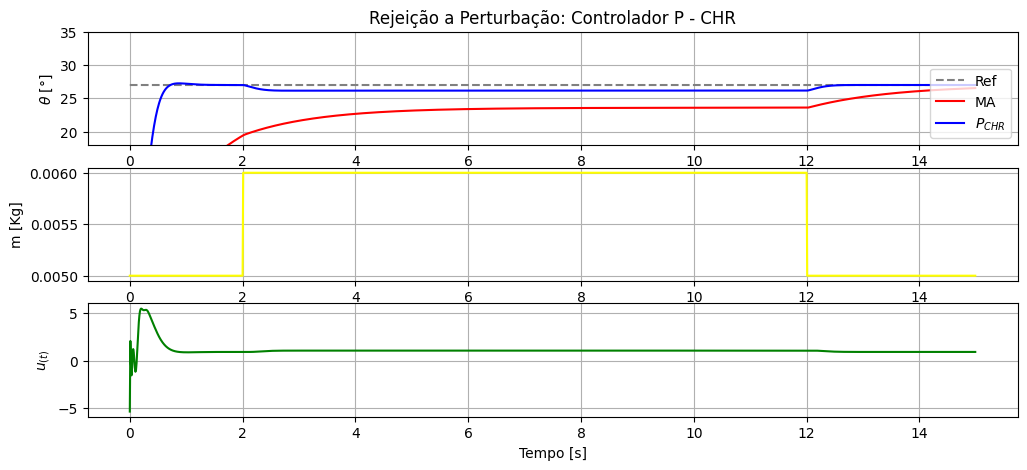

In [23]:
# Simulando Malha Fechada:
X0 = np.zeros(7)
tm, xout = ct.input_output_response(closed_loop2, tm, [rm, u0, mv], X0)
mcpchr = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(14)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(3, 1, 1)
plt.plot(tm, np.degrees(rm), 'gray', linestyle='dashed', label='Ref')
plt.plot(tm, np.degrees(ma), 'red', label='MA')
plt.plot(tm, np.degrees(mcpchr),'blue',label='$P_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('Rejeição a Perturbação: Controlador P - CHR')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(tm, mv, 'yellow', label='$m_{(t)}$')
plt.ylabel('m [Kg]')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(tm, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Controlador Proporcional Integral - Ziegler Nichols:

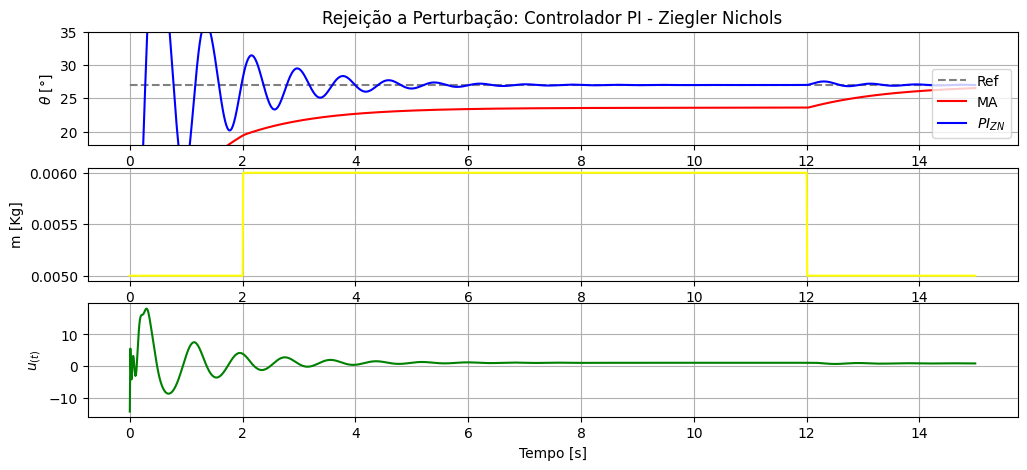

In [24]:
# Simulando Malha Fechada:
X0 = np.zeros(7)
tm, xout = ct.input_output_response(closed_loop3, tm, [rm, rm, u0, mv], X0)
mcpizn = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(15)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(3, 1, 1)
plt.plot(tm, np.degrees(rm), 'gray', linestyle='dashed', label='Ref')
plt.plot(tm, np.degrees(ma), 'red', label='MA')
plt.plot(tm, np.degrees(mcpizn),'blue',label='$PI_{ZN}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('Rejeição a Perturbação: Controlador PI - Ziegler Nichols')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(tm, mv, 'yellow', label='$m_{(t)}$')
plt.ylabel('m [Kg]')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(tm, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Controlador Proporcional Integral - CHR:

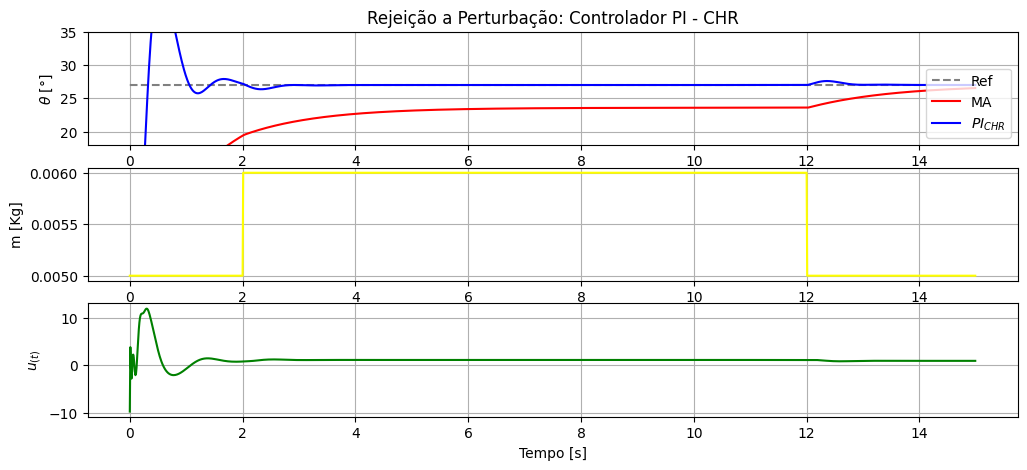

In [25]:
# Simulando Malha Fechada:
X0 = np.zeros(7)
tm, xout = ct.input_output_response(closed_loop4, tm, [rm, rm, u0, mv], X0)
mcpichr = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(16)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(3, 1, 1)
plt.plot(tm, np.degrees(rm), 'gray', linestyle='dashed', label='Ref')
plt.plot(tm, np.degrees(ma), 'red', label='MA')
plt.plot(tm, np.degrees(mcpichr),'blue',label='$PI_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('Rejeição a Perturbação: Controlador PI - CHR')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(tm, mv, 'yellow', label='$m_{(t)}$')
plt.ylabel('m [Kg]')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(tm, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Comparação entre os controladores:

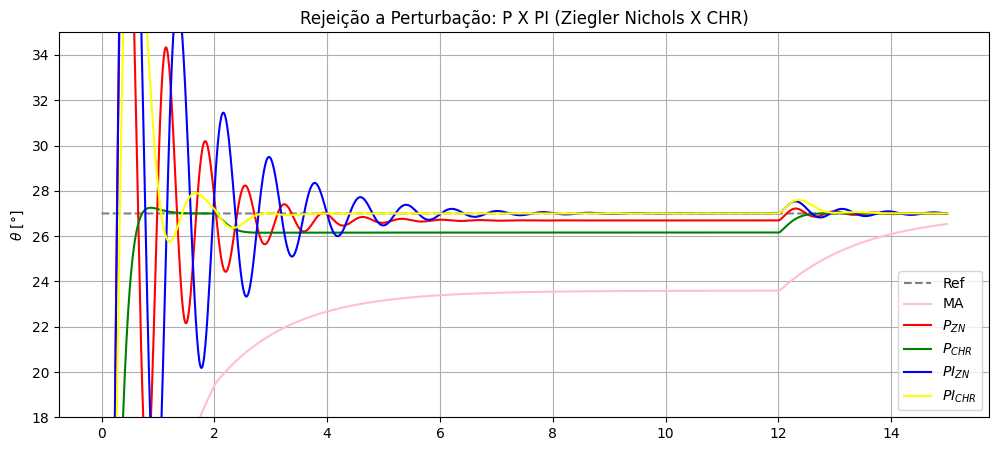

In [26]:
#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(17)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(tm, np.degrees(rm), 'gray', linestyle='dashed', label='Ref')
plt.plot(tm, np.degrees(ma), 'pink', label='MA')
plt.plot(tm, np.degrees(mcpzn),'red',label='$P_{ZN}$')
plt.plot(tm, np.degrees(mcpchr),'green',label='$P_{CHR}$')
plt.plot(tm, np.degrees(mcpizn),'blue',label='$PI_{ZN}$')
plt.plot(tm, np.degrees(mcpichr),'yellow',label='$PI_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.ylim(18, 35)
plt.title('Rejeição a Perturbação: P X PI (Ziegler Nichols X CHR)')
plt.grid()
plt.show()

### 👉 Item 12:

* Análise do transitório:

In [27]:
#Array de tempo:
tt = np.arange(0, 8, .01)

#Massa constante:
mc = mt*np.ones(tt.shape)

#Sinais de controle:
rt = np.radians(pop)*np.ones(tt.shape)
u0 = u_eq*np.ones(tt.shape)
u = u_eq*np.ones(tt.shape)

# Malha aberta:
X0 = [0, 0]
tt, xout = ct.input_output_response(fanplate, tt, [u, mc], X0)
ma = xout[0]

* Controlador Proporcional - Ziegler Nichols:

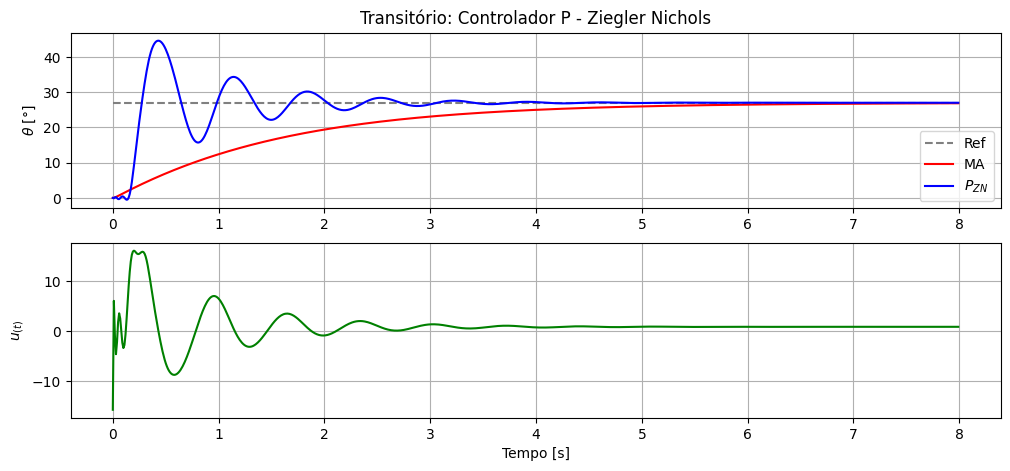

In [28]:
# Simulando a Malha Fechada:
X0 = np.zeros(7)
tt, xout = ct.input_output_response(closed_loop1, tt, [rt, u0, mc], X0)
tcpzn = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(18)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(tt, np.degrees(rt), 'gray', linestyle='dashed', label='Ref')
plt.plot(tt, np.degrees(ma), 'red', label='MA')
plt.plot(tt, np.degrees(tcpzn),'blue',label='$P_{ZN}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.title('Transitório: Controlador P - Ziegler Nichols')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(tt, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()

plt.show()

* Controlador Proporcional - CHR:

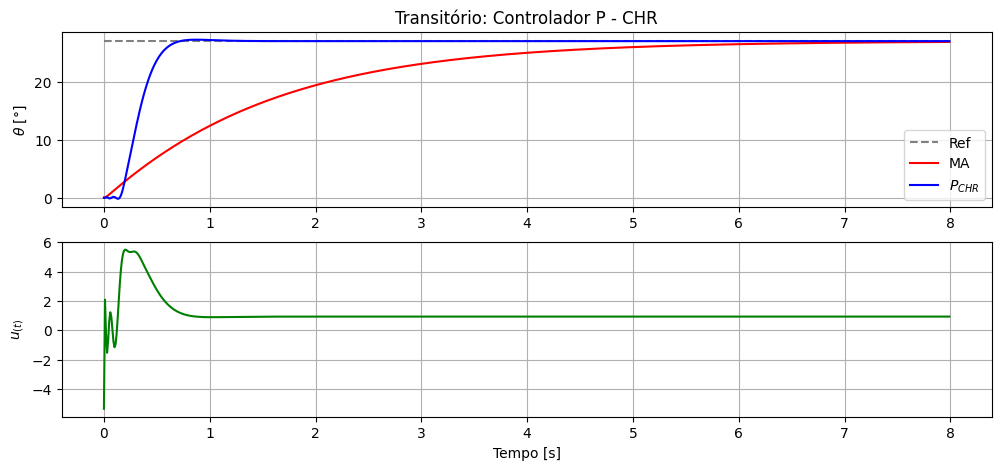

In [29]:
# Simulando Malha Fechada:
X0 = np.zeros(7)
tt, xout = ct.input_output_response(closed_loop2, tt, [rt, u0, mc], X0)
tcpchr = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(19)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(tt, np.degrees(rt), 'gray', linestyle='dashed', label='Ref')
plt.plot(tt, np.degrees(ma), 'red', label='MA')
plt.plot(tt, np.degrees(tcpchr),'blue',label='$P_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.title('Transitório: Controlador P - CHR')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(tt, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Controlador Proporcional Integral - Ziegler Nichols:

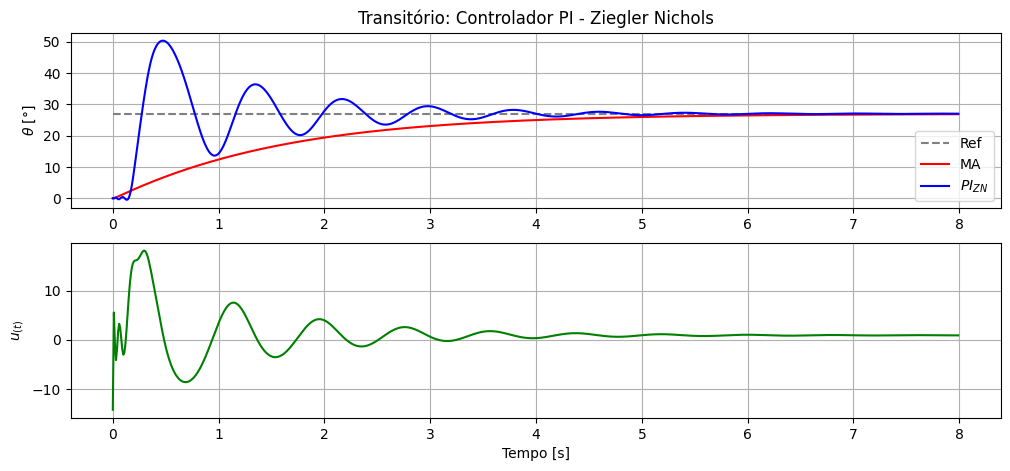

In [30]:
# Simulando Malha Fechada:
X0 = np.zeros(7)
tt, xout = ct.input_output_response(closed_loop3, tt, [rt, rt, u0, mc], X0)
tcpizn = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(20)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(tt, np.degrees(rt), 'gray', linestyle='dashed', label='Ref')
plt.plot(tt, np.degrees(ma), 'red', label='MA')
plt.plot(tt, np.degrees(tcpizn),'blue',label='$PI_{ZN}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.title('Transitório: Controlador PI - Ziegler Nichols')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(tt, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Controlador Proporcional Integral - CHR:

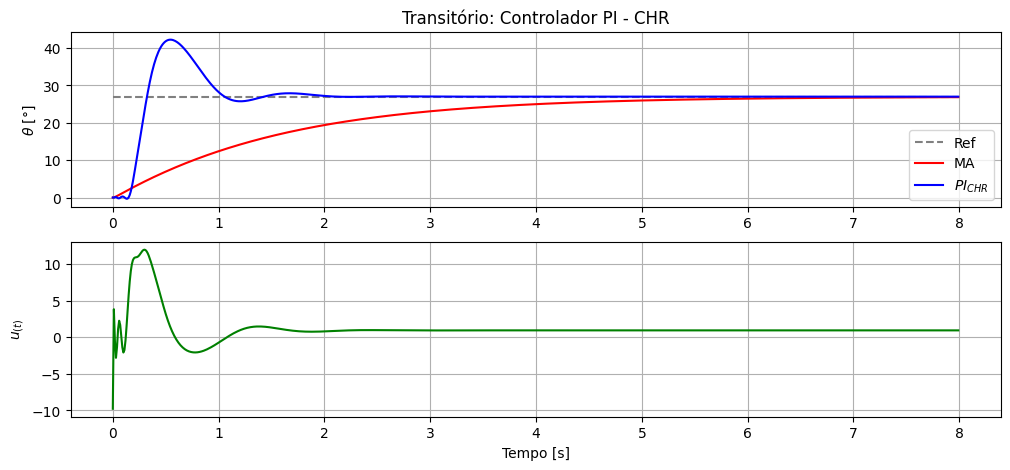

In [31]:
# Simulando Malha Fechada:
X0 = np.zeros(7)
tt, xout = ct.input_output_response(closed_loop4, tt, [rt, rt, u0, mc], X0)
tcpichr = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(21)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(tt, np.degrees(rt), 'gray', linestyle='dashed', label='Ref')
plt.plot(tt, np.degrees(ma), 'red', label='MA')
plt.plot(tt, np.degrees(tcpichr),'blue',label='$PI_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.title('Transitório: Controlador PI - CHR')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(tt, xout[2], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Comparação entre os controladores:

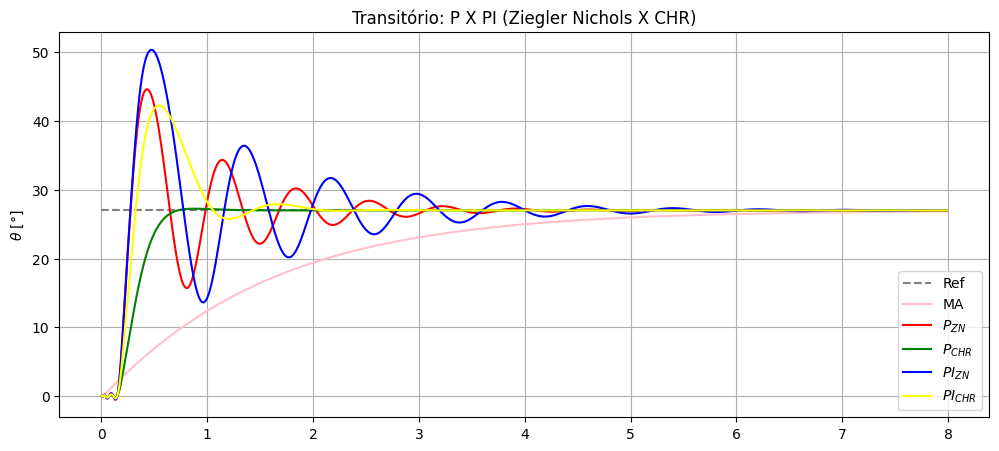

In [32]:
#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(21)
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(tt, np.degrees(rt), 'gray', linestyle='dashed', label='Ref')
plt.plot(tt, np.degrees(ma), 'pink', label='MA')
plt.plot(tt, np.degrees(tcpzn),'red',label='$P_{ZN}$')
plt.plot(tt, np.degrees(tcpchr),'green',label='$P_{CHR}$')
plt.plot(tt, np.degrees(tcpizn),'blue',label='$PI_{ZN}$')
plt.plot(tt, np.degrees(tcpichr),'yellow',label='$PI_{CHR}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.title('Transitório: P X PI (Ziegler Nichols X CHR)')
plt.grid()
plt.show()

* Parâmetros P - Ziegler Nichols:

In [33]:
print('\n Parâmetros Controlador P - Ziegler Nichols:')

#Tempo de pico:
tp_pzn = tt[np.where(tcpzn == np.max(tcpzn))][0]
print(f'\n Tp: \t\t {round(tp_pzn, 4)} s')

#Overshoot:
Mp_pzn = ((np.degrees(tcpzn[np.where(tt == tp_pzn)][0])-pop)/pop)
print(f'\n Mp: \t\t {round(Mp_pzn, 4)} %')

#Coeficiente de amortecimento:
zeta_pzn = (-np.log(Mp_pzn)/(np.sqrt((np.pi**2) + (np.log(Mp_pzn)**2))))
print(f'\n zeta: \t\t {round(zeta_pzn, 4)}')

#Frequência natural:
omega_pzn = np.pi/(tp_pzn*np.sqrt(1-(zeta_pzn**2)))
print(f'\n omega_n: \t {round(omega_pzn, 4)} rad/s')

#Tempo de acomodação:
ts2_pzn = 4/(zeta_pzn*omega_pzn)
ts5_pzn = 3/(zeta_pzn*omega_pzn)
print(f'\n Ts2: \t\t {round(ts2_pzn, 4)} s')
print(f'\n Ts5: \t\t {round(ts5_pzn, 4)} s')


 Parâmetros Controlador P - Ziegler Nichols:

 Tp: 		 0.43 s

 Mp: 		 0.6525 %

 zeta: 		 0.1347

 omega_n: 	 7.3732 rad/s

 Ts2: 		 4.0289 s

 Ts5: 		 3.0217 s


* Parâmetros P - CHR:

In [34]:
print('\n Parâmetros Controlador P - CHR:')

#Tempo de pico:
tp_pchr = tt[np.where(tcpchr == np.max(tcpchr))][0]
print(f'\n Tp: \t\t {round(tp_pchr, 4)} s')

#Overshoot:
Mp_pchr = ((np.degrees(tcpchr[np.where(tt == tp_pchr)][0])-pop)/pop)
print(f'\n Mp: \t\t {round(Mp_pchr, 4)} %')

#Coeficiente de amortecimento:
zeta_pchr = (-np.log(Mp_pchr)/(np.sqrt((np.pi**2) + (np.log(Mp_pchr)**2))))
print(f'\n zeta: \t\t {round(zeta_pchr, 4)}')

#Frequência natural:
omega_pchr = np.pi/(tp_pchr*np.sqrt(1-(zeta_pchr**2)))
print(f'\n omega_n: \t {round(omega_pchr, 4)} rad/s')

#Tempo de acomodação:
ts2_pchr = 4/(zeta_pchr*omega_pchr)
ts5_pchr = 3/(zeta_pchr*omega_pchr)
print(f'\n Ts2: \t\t {round(ts2_pchr, 4)} s')
print(f'\n Ts5: \t\t {round(ts5_pchr, 4)} s')


 Parâmetros Controlador P - CHR:

 Tp: 		 0.87 s

 Mp: 		 0.0093 %

 zeta: 		 0.8302

 omega_n: 	 6.478 rad/s

 Ts2: 		 0.7437 s

 Ts5: 		 0.5578 s


* Parâmetros PI - Ziegler Nichols:

In [35]:
print('\n Parâmetros Controlador PI - Ziegler Nichols:')

#Tempo de pico:
tp_pizn = tt[np.where(tcpizn == np.max(tcpizn))][0]
print(f'\n Tp: \t\t {round(tp_pizn, 4)} s')

#Overshoot:
Mp_pizn = ((np.degrees(tcpizn[np.where(tt == tp_pzn)][0])-pop)/pop)
print(f'\n Mp: \t\t {round(Mp_pizn, 4)} %')

#Coeficiente de amortecimento:
zeta_pizn = (-np.log(Mp_pizn)/(np.sqrt((np.pi**2) + (np.log(Mp_pizn)**2))))
print(f'\n zeta: \t\t {round(zeta_pizn, 4)}')

#Frequência natural:
omega_pizn = np.pi/(tp_pizn*np.sqrt(1-(zeta_pizn**2)))
print(f'\n omega_n: \t {round(omega_pizn, 4)} rad/s')

#Tempo de acomodação:
ts2_pizn = 4/(zeta_pizn*omega_pizn)
ts5_pizn = 3/(zeta_pizn*omega_pizn)
print(f'\n Ts2: \t\t {round(ts2_pizn, 4)} s')
print(f'\n Ts5: \t\t {round(ts5_pizn, 4)} s')


 Parâmetros Controlador PI - Ziegler Nichols:

 Tp: 		 0.47 s

 Mp: 		 0.8353 %

 zeta: 		 0.0572

 omega_n: 	 6.6952 rad/s

 Ts2: 		 10.4433 s

 Ts5: 		 7.8325 s


* Parâmetros PI - CHR:

In [36]:
print('\n Parâmetros Controlador PI - CHR:')

#Tempo de pico:
tp_pichr = tt[np.where(tcpichr == np.max(tcpichr))][0]
print(f'\n Tp: \t\t {round(tp_pichr, 4)} s')

#Overshoot:
Mp_pichr = ((np.degrees(tcpichr[np.where(tt == tp_pichr)][0])-pop)/pop)
print(f'\n Mp: \t\t {round(Mp_pichr, 4)} %')

#Coeficiente de amortecimento:
zeta_pichr = (-np.log(Mp_pichr)/(np.sqrt((np.pi**2) + (np.log(Mp_pichr)**2))))
print(f'\n zeta: \t\t {round(zeta_pichr, 4)}')

#Frequência natural:
omega_pichr = np.pi/(tp_pichr*np.sqrt(1-(zeta_pichr**2)))
print(f'\n omega_n: \t {round(omega_pichr, 4)} rad/s')

#Tempo de acomodação:
ts2_pichr = 4/(zeta_pichr*omega_pichr)
ts5_pichr = 3/(zeta_pichr*omega_pichr)
print(f'\n Ts2: \t\t {round(ts2_pichr, 4)} s')
print(f'\n Ts5: \t\t {round(ts5_pichr, 4)} s')


 Parâmetros Controlador PI - CHR:

 Tp: 		 0.54 s

 Mp: 		 0.5648 %

 zeta: 		 0.1789

 omega_n: 	 5.9132 rad/s

 Ts2: 		 3.7805 s

 Ts5: 		 2.8354 s


* Análise de desempenho  Controlador P - Ziegler Nichols:

In [37]:
IAE = np.sum(np.abs((cpzn-r)*0.01))
ITAE = np.sum(np.abs((cpzn-r)*0.01*t))
RMSE = np.sqrt(np.mean(np.abs(cpzn-r)**2))

print('\n Índices de Desempenho Controlador P - Ziegler Nichols')
print(f'\n IAE: \t {round(IAE, 4)}')
print(f'\n ITAE: \t {round(ITAE, 4)}')
print(f'\n RMSE: \t {round(RMSE, 4)}')


 Índices de Desempenho Controlador P - Ziegler Nichols

 IAE: 	 0.8542

 ITAE: 	 18.0377

 RMSE: 	 0.0386


* Análise de desempenho  Controlador P - CHR:

In [38]:
IAE = np.sum(np.abs((cpchr-r)*0.01))
ITAE = np.sum(np.abs((cpchr-r)*0.01*t))
RMSE = np.sqrt(np.mean(np.abs(cpchr-r)**2))

print('\n Índices de Desempenho Controlador P - CHR')
print(f'\n IAE: \t {round(IAE, 4)}')
print(f'\n ITAE: \t {round(ITAE, 4)}')
print(f'\n RMSE: \t {round(RMSE, 4)}')


 Índices de Desempenho Controlador P - CHR

 IAE: 	 0.9925

 ITAE: 	 26.2909

 RMSE: 	 0.037


* Análise de desempenho  Controlador PI - Ziegler Nichols:

In [39]:
IAE = np.sum(np.abs((cpizn-r)*0.01))
ITAE = np.sum(np.abs((cpizn-r)*0.01*t))
RMSE = np.sqrt(np.mean(np.abs(cpizn-r)**2))

print('\n Índices de Desempenho Controlador PI - Ziegler Nichols')
print(f'\n IAE: \t {round(IAE, 4)}')
print(f'\n ITAE: \t {round(ITAE, 4)}')
print(f'\n RMSE: \t {round(RMSE, 4)}')


 Índices de Desempenho Controlador PI - Ziegler Nichols

 IAE: 	 1.1166

 ITAE: 	 22.7708

 RMSE: 	 0.0479


* Análise de desempenho  Controlador PI - CHR:

In [40]:
IAE = np.sum(np.abs((cpichr-r)*0.01))
ITAE = np.sum(np.abs((cpichr-r)*0.01*t))
RMSE = np.sqrt(np.mean(np.abs(cpichr-r)**2))

print('\n Índices de Desempenho Controlador PI - CHR')
print(f'\n IAE: \t {round(IAE, 4)}')
print(f'\n ITAE: \t {round(ITAE, 4)}')
print(f'\n RMSE: \t {round(RMSE, 4)}')


 Índices de Desempenho Controlador PI - CHR

 IAE: 	 0.5385

 ITAE: 	 9.4359

 RMSE: 	 0.0377
